In [28]:
import warnings
warnings.filterwarnings("ignore")

# import librosa
import torchaudio as ta
ta.set_audio_backend("sox")
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd.profiler as profiler
import pytorch_lightning as pl

import numpy as np
import os

import IPython.display as ipd

import numpy as np

import math

import glob

from tqdm.auto import tqdm

from python_files.Noise_Reduction_Datagen_paths import Signal_Synthesis_DataGen
# from python_files.unet_basic import Model

import warnings

warnings.filterwarnings("ignore")

import gc

from random import shuffle

import matplotlib.pyplot as plt

# from numba import jit

In [2]:
from tqdm.auto import tqdm

In [3]:
from fastai.text.all import *
from fastai.data.core import DataLoaders

In [4]:
import fastai

fastai.__version__

'2.1.6'

In [5]:
torch.backends.cudnn.version()

8004

In [6]:
torch.backends.cudnn.benchmark = True

torch.__version__

'1.8.0a0+16f4b0e'

In [8]:
def get_paths(dir_path):
    paths = []
    for root, dirs, files in os.walk(dir_path):
        for name in files:
            if name.endswith(".wav") or name.endswith(".mp3"):
                paths.append(os.path.join(root, name))
                
    paths = np.asarray(paths)
    return paths

In [9]:
noise_paths_sh = get_paths("./dataset/Reduced_noise/")
shuffle(noise_paths_sh)

signal_paths_sh = get_paths("./dataset/Reduced_clean_signals/")
shuffle(signal_paths_sh)

In [10]:
noise_paths = noise_paths_sh[:-500]
signal_paths = signal_paths_sh[:10000]
signal_dir = ""#"./dataset/cv-corpus-5.1-2020-06-22-Resampled/en/clips"
noise_save_path = ""#"./dataset_loader_files/noise_paths_resampled_save.npy"
train = True
n_fft=1024
win_length=n_fft
hop_len=n_fft//4
create_specgram = False
perform_stft = False
default_sr = 16000
sec = (16384/default_sr)*2
augment=True
device_datagen = "cpu"

train_ds = Signal_Synthesis_DataGen(noise_paths, signal_paths, signal_dir, \
                 n_fft=n_fft, win_length=win_length, hop_len=hop_len, create_specgram=create_specgram, \
                 perform_stft=perform_stft, normalize=True, default_sr=default_sr, sec=sec, epsilon=1e-5, augment=False, device=device_datagen)

10000 ./dataset/Reduced_clean_signals/common_voice_en_693201.mp3


In [11]:
noise_paths = noise_paths_sh[-500:]
signal_paths = signal_paths_sh[10000:10500]
signal_dir = ""#"./dataset/cv-corpus-5.1-2020-06-22-Resampled/en/clips"
noise_save_path = ""#"./dataset_loader_files/noise_paths_resampled_save.npy"
train = False

val_ds = Signal_Synthesis_DataGen(noise_paths, signal_paths, signal_dir,\
                 n_fft=n_fft, win_length=win_length, hop_len=hop_len, create_specgram=create_specgram, \
                 perform_stft=perform_stft, normalize=True, default_sr=default_sr, sec=sec, epsilon=1e-5, augment=False, device=device_datagen)

500 ./dataset/Reduced_clean_signals/common_voice_en_17902094.mp3


In [14]:
device = "cpu"

BATCH_SIZE = 104
shuffle = True
num_workers = 0
pin_memory = False

dls = DataLoaders.from_dsets(train_ds, val_ds, bs=BATCH_SIZE, num_workers=num_workers, pin_memory=pin_memory).to(device)

In [15]:
class Mod_MSELoss(nn.Module):
    def __init__(self, mul_factor):
        super(Mod_MSELoss, self).__init__()
        self.loss_fn = nn.MSELoss(reduction="mean")
        self.mul_factor = mul_factor
        
        
    def forward(self, sig_pred, sig_true):
        loss = self.loss_fn(sig_pred, sig_true)
        loss = self.mul_factor*loss
        return loss

In [16]:
class DownSamplingLayer(nn.Module):
    def __init__(self, channel_in, channel_out, dilation=1, kernel_size=15, stride=1, padding=7):
        super(DownSamplingLayer, self).__init__()
        self.main = nn.Sequential(
            nn.Conv1d(channel_in, channel_out, kernel_size=kernel_size,
                      stride=stride, padding=padding, dilation=dilation),
            nn.BatchNorm1d(channel_out),
            nn.LeakyReLU(negative_slope=0.1)
        )

    def forward(self, ipt):
        return self.main(ipt)

class UpSamplingLayer(nn.Module):
    def __init__(self, channel_in, channel_out, kernel_size=5, stride=1, padding=2):
        super(UpSamplingLayer, self).__init__()
        self.main = nn.Sequential(
            nn.Conv1d(channel_in, channel_out, kernel_size=kernel_size,
                      stride=stride, padding=padding),
            nn.BatchNorm1d(channel_out),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
        )

    def forward(self, ipt):
        return self.main(ipt)

class Model(pl.LightningModule):
    def __init__(self, n_layers=12, channels_interval=24):
        super(Model, self).__init__()
        self.loss_fn = Mod_MSELoss(mul_factor=1000)
        self.n_layers = n_layers
        self.channels_interval = channels_interval
        encoder_in_channels_list = [1] + [i * self.channels_interval for i in range(1, self.n_layers)]
        encoder_out_channels_list = [i * self.channels_interval for i in range(1, self.n_layers + 1)]

        #          1    => 2    => 3    => 4    => 5    => 6   => 7   => 8   => 9  => 10 => 11 =>12
        # 16384 => 8192 => 4096 => 2048 => 1024 => 512 => 256 => 128 => 64 => 32 => 16 =>  8 => 4
        self.encoder = nn.ModuleList()
        for i in range(self.n_layers):
            self.encoder.append(
                DownSamplingLayer(
                    channel_in=encoder_in_channels_list[i],
                    channel_out=encoder_out_channels_list[i]
                )
            )

        self.middle = nn.Sequential(
            nn.Conv1d(self.n_layers * self.channels_interval, self.n_layers * self.channels_interval, 15, stride=1,
                      padding=7),
            nn.BatchNorm1d(self.n_layers * self.channels_interval),
            nn.LeakyReLU(negative_slope=0.1, inplace=True)
        )

        decoder_in_channels_list = [(2 * i + 1) * self.channels_interval for i in range(1, self.n_layers)] + [
            2 * self.n_layers * self.channels_interval]
        decoder_in_channels_list = decoder_in_channels_list[::-1]
        decoder_out_channels_list = encoder_out_channels_list[::-1]
        self.decoder = nn.ModuleList()
        for i in range(self.n_layers):
            self.decoder.append(
                UpSamplingLayer(
                    channel_in=decoder_in_channels_list[i],
                    channel_out=decoder_out_channels_list[i]
                )
            )

        self.out = nn.Sequential(
            nn.Conv1d(1 + self.channels_interval, 1, kernel_size=1, stride=1),
            nn.Tanh()
        )

    def forward(self, input):
        tmp = []
        o = input

        # Up Sampling
        for i in range(self.n_layers):
            o = self.encoder[i](o)
#             print(o.shape)
            tmp.append(o)
            # [batch_size, T // 2, channels]
            o = o[:, :, ::2]

        o = self.middle(o)

        # Down Sampling
        for i in range(self.n_layers):
            # [batch_size, T * 2, channels]
            o = F.interpolate(o, scale_factor=2, mode="linear", align_corners=True)
            # Skip Connection
            # print(o.shape, len(tmp))
            o = torch.cat([o, tmp[self.n_layers - i -1]], dim=1)
            o = self.decoder[i](o)

        o = torch.cat([o, input], dim=1)
        o = self.out(o)
        return o

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x.unsqueeze(dim=1).to(device))
        loss = self.loss_fn(y_pred, y.unsqueeze(dim=1))

        return loss
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x.unsqueeze(dim=1).to(device))
        
        loss = self.loss_fn(y_pred, y.unsqueeze(dim=1))
        self.log("val_loss", loss, enable_graph=True, on_epoch=True, prog_bar=True)
    
    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=0.001, weight_decay=5e-5)

In [34]:
device="cuda"

In [42]:
model = Model()
model.load_state_dict(torch.load("./Model_saves/cnn_model_best_1_78.pth"))
model.to(device)

Model(
  (loss_fn): Mod_MSELoss(
    (loss_fn): MSELoss()
  )
  (encoder): ModuleList(
    (0): DownSamplingLayer(
      (main): Sequential(
        (0): Conv1d(1, 24, kernel_size=(15,), stride=(1,), padding=(7,))
        (1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1)
      )
    )
    (1): DownSamplingLayer(
      (main): Sequential(
        (0): Conv1d(24, 48, kernel_size=(15,), stride=(1,), padding=(7,))
        (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1)
      )
    )
    (2): DownSamplingLayer(
      (main): Sequential(
        (0): Conv1d(48, 72, kernel_size=(15,), stride=(1,), padding=(7,))
        (1): BatchNorm1d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1)
      )
    )
    (3): DownSamplingLayer(
      (main): Sequential(
        (0): Conv1d(72, 96

In [46]:
%%time
noise_add_sig, main_sig = val_ds.__getitem__(2345)
noise_add_sig = torch.unsqueeze(noise_add_sig, dim=0).to(device)
main_sig = torch.unsqueeze(main_sig, dim=0).to(device)

with torch.no_grad():
    outs = model(noise_add_sig).squeeze()

outs.shape

x = outs.t().to("cpu").numpy()
ipd.Audio(x, rate=default_sr)

CPU times: user 111 ms, sys: 8.12 ms, total: 119 ms
Wall time: 51.5 ms


In [47]:
x = noise_add_sig.squeeze().t().to("cpu").numpy()
ipd.Audio(x, rate=default_sr)

In [48]:
x = main_sig.squeeze().t().to("cpu").numpy()
ipd.Audio(x, rate=default_sr)

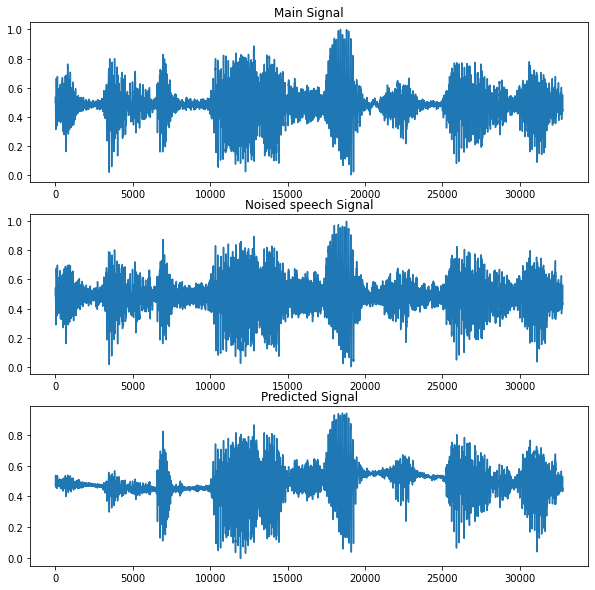

In [50]:
fig, axes = plt.subplots(3, 1, figsize=(10, 10))
axes[0].plot(main_sig.squeeze().t().to("cpu").numpy())
axes[1].plot(noise_add_sig.squeeze().t().to("cpu").numpy())
axes[2].plot(outs.t().squeeze().to("cpu").numpy())

axes[0].title.set_text("Main Signal")
axes[1].title.set_text("Noised speech Signal")
axes[2].title.set_text("Predicted Signal")

fig.show()